In [1]:
from src.functions import *

In [15]:
n=4
T=0.5
t_max=10
interpolator_kind='cubic'
n_random_models = 10
n_iter = 500

In [16]:
def loss_ra(ramp_up_schedule):
    '''
    Computes the negative average delta for multiple random Ising models 
    using for a given ramp-up schedule and maximum time.
    '''
    schedule = get_symmetric_schedule(ramp_up_schedule) # mirror and append the ramp up schedule
    schedule_interpolator = get_schedule_interpolator(schedule, kind=interpolator_kind) # get an interpolating function for the continuos schedule
    
    delta_sum = 0    
    for seed in range(n_random_models):
        m = RandomIsingModel(n=n, seed=seed)
        proposal_mat_ra = get_proposal_mat_ra(m, schedule_interpolator, t_max, assert_symmetry=False)
        P = get_transition_matrix(m, T, proposal_mat_ra)
        delta_sum += get_delta(P)
    
    delta_avg = delta_sum / n_random_models
    return -delta_avg

Initial spectral gap =  0.0704


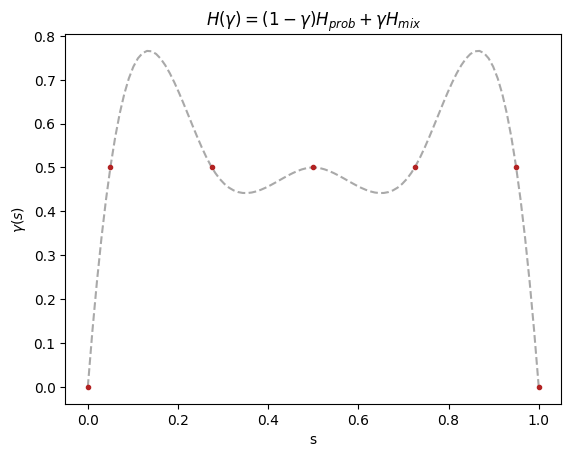

In [17]:
f_max = 0.5
ramp_up_schedule_init = np.ones(3)*f_max

loss_init = loss_ra(ramp_up_schedule_init)
print('Initial spectral gap = ', -loss_init.round(4))

schedule_init = get_symmetric_schedule(ramp_up_schedule_init) # mirror and append the ramp up schedule
plot_schedule(schedule_init, get_schedule_interpolator(schedule_init, interpolator_kind))


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    1   F =-7.037831E-02    MAXCV = 0.000000E+00
   X = 5.000000E-01   5.000000E-01   5.000000E-01
Optimized spectral gap =  0.0704


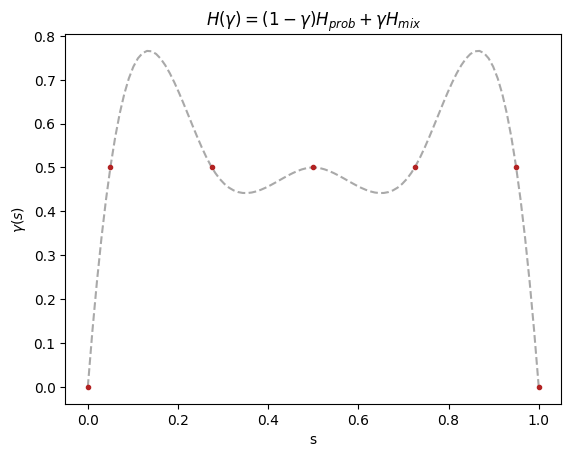

In [19]:
bounds = ((0,1), (0,1), (0,1))

res = minimize(loss_ra, 
               ramp_up_schedule_init,
               method='COBYLA',
               bounds=bounds,
               options={"disp":True, "maxiter":n_iter})  

loss_opt = loss_ra(res.x)
print('Optimized spectral gap = ', -loss_opt.round(4))

schedule_opt = get_symmetric_schedule(res.x)
plot_schedule(schedule_opt, get_schedule_interpolator(schedule_opt, interpolator_kind)) 

Optimized spectral gap =  0.1355


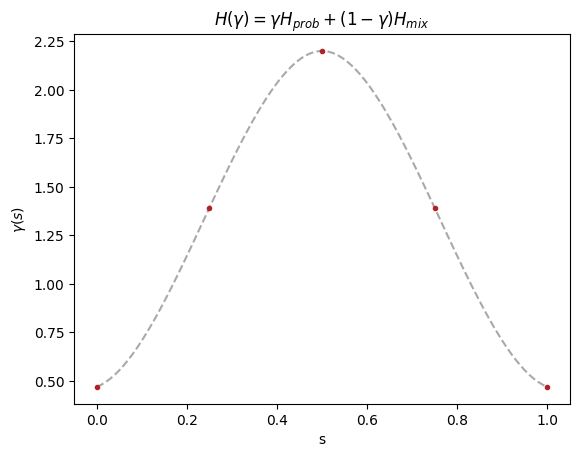

In [83]:
# res_finetuned = minimize(loss_ra, 
#                          res.x, 
#                          method='L-BFGS-B',
#                          options={"disp":True, "maxiter":200})

# loss_finetuned = loss_ra(res_finetuned.x)
# print('Optimized spectral gap = ', -loss_finetuned.round(4))

# schedule_finetuned = get_symmetric_schedule(res_finetuned.x)
# plot_schedule(schedule_finetuned, get_schedule_interpolator(schedule_finetuned, interpolator_kind)) 

In [ ]:
ra_exp = {'n': n,
          'T': T,
          'interpolator_kind': interpolator_kind,
          't_max': t_max,
          'schedule_opt': schedule_opt.tolist(),
          'loss_opt': loss_opt,
          'first_optimizer': 'COBYLA',
          'second_optimizer': 'None',
          'n_random_models': n_random_models,
          'n_iter': n_iter
          }

save_in_json(ra_exp, f'standard_optim_cluster/n{n}_{interpolator_kind}_COBYLA_TEST.json')